# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model CNN yang mampu mendeteksi apakah terjadi kebakaran atau tidak.

## Import Libraries

Pada project ini library yang akan digunakan adalah **Pandas**, **Numpy**, **Matplotlib**, **Seaborn**, **Tensorflow**, **Keras**, dan **Scikit-Learn**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

Membuat dataframe yang berisi path dari gambar berikut labelnya.

In [3]:
# Create an empty dataframe
fire = pd.DataFrame(columns=['image', 'label'])

# Loop through fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'fire'}, ignore_index=True)

# Loop through non_fire_images directory and add each image and label to the dataframe
for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/non_fire_images'):
    for filename in filenames:
        fire = fire.append({'image': os.path.join(dirpath, filename), 'label': 'non_fire'}, ignore_index=True)
        
# Shuffle the dataframe
fire = fire.sample(frac=1).reset_index(drop=True)

In [4]:
fire.head(20)

,image,label
0,dataset/fire_dataset/fire_images\fire.426.png,fire
1,dataset/fire_dataset/fire_images\fire.127.png,fire
2,dataset/fire_dataset/non_fire_images\non_fire....,non_fire
3,dataset/fire_dataset/fire_images\fire.448.png,fire
4,dataset/fire_dataset/fire_images\fire.511.png,fire
5,dataset/fire_dataset/fire_images\fire.746.png,fire
6,dataset/fire_dataset/non_fire_images\house5.jpg,non_fire
7,dataset/fire_dataset/fire_images\fire.646.png,fire
8,dataset/fire_dataset/non_fire_images\d=23&p=99...,non_fire
9,dataset/fire_dataset/non_fire_images\18 Petrog...,non_fire


In [5]:
fire.shape

(1366, 2)

Data ini berisi **999 gambar** dengan 2 label yaitu **fire** dan **non_fire**.

## Exploratory Data Analysis (EDA)

### Label

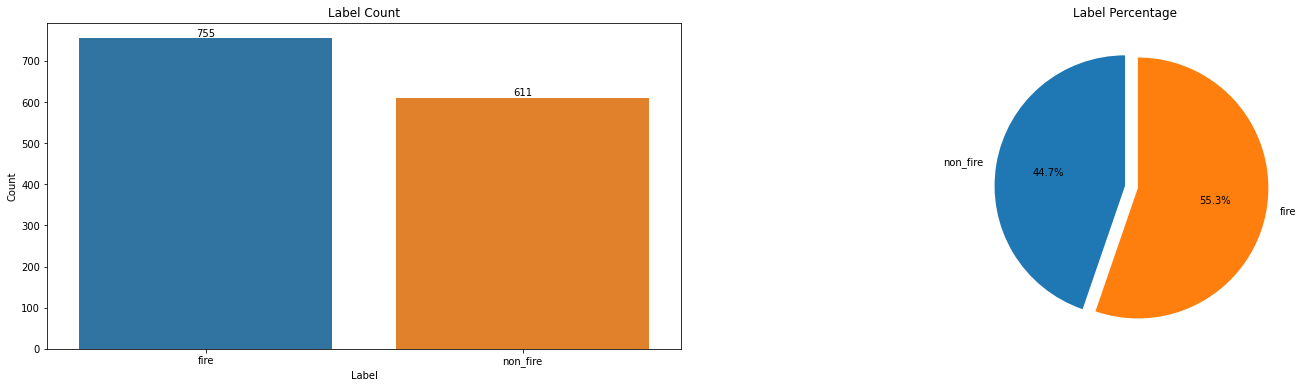

In [6]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x() + p.get_width()/2., height + 0.5, height, ha='center', va='bottom')
plt.title('Label Count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire['label'].value_counts().reindex(['non_fire', 'fire']), labels=fire.label.value_counts().reindex(['non_fire', 'fire']).index, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
plt.title('Label Percentage')
plt.show()

Pada dataset terdapat **label imbalanced** dimana jumlah gambar berlabel non_fire lebih sedikit dibandingkan gambar berlabel fire yaitu hanya **244 gambar** atau sekitar **24%** gambar saja yang memiliki label non_fire.

### Fire Image Samples

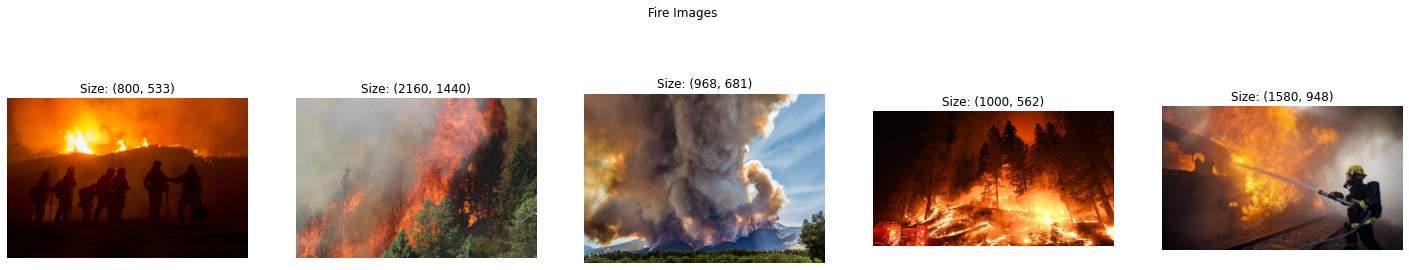

In [7]:
plt.figure(figsize=(25, 5))
plt.suptitle('Fire Images')
for i in range(5):
    img = image.load_img(fire[fire.label == 'fire'].sample(1).image.values[0])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Plot diatas merupakan 5 sample dari gambar dengan yang berlabel **fire**, jika dilihat setiap gambar memiliki ukuran yang berbeda-beda.

### Non Fire Image Samples

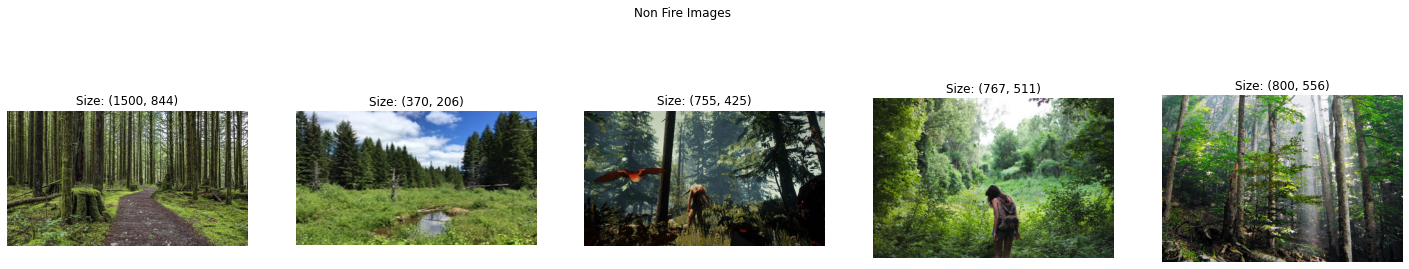

In [8]:
plt.figure(figsize=(25, 5))
plt.suptitle('Non Fire Images')
for i in range(5):
    img = image.load_img(fire[fire.label == 'non_fire'].sample(1).image.values[0])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Gambar diatas merupakah sample dari gambar yang berlabel **non_fire**. Sama seperti gambar dengan label fire, gambar-gambar diatas juga memiliki ukuran yang berbeda untuk setiap gambarnya.

## Data Preprocessing

In [9]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [10]:
train_generator = generator.flow_from_dataframe(dataframe=fire, x_col='image', y_col='label', subset='training', batch_size=32, class_mode='binary', shuffle=True, seed=23, target_size=(224, 224))
validation_generator = generator.flow_from_dataframe(dataframe=fire, x_col='image', y_col='label', subset='validation', batch_size=32, class_mode='binary', shuffle=True, seed=23, target_size=(224, 224))

Found 1093 validated image filenames belonging to 2 classes.
Found 273 validated image filenames belonging to 2 classes.


## Model Definition

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 dropout_5 (Dropout)         (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                  

## Model Training

In [28]:
# Compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
35/35 [==============================] - 31s 847ms/step - loss: 0.8417 - accuracy: 0.7374 - val_loss: 0.5029 - val_accuracy: 0.8608
Epoch 2/30
35/35 [==============================] - 29s 837ms/step - loss: 0.3813 - accuracy: 0.8536 - val_loss: 0.5510 - val_accuracy: 0.7033
Epoch 3/30
35/35 [==============================] - 29s 833ms/step - loss: 0.5441 - accuracy: 0.8234 - val_loss: 0.3862 - val_accuracy: 0.8864
Epoch 4/30
35/35 [==============================] - 29s 838ms/step - loss: 0.3698 - accuracy: 0.8554 - val_loss: 0.3888 - val_accuracy: 0.8718
Epoch 5/30
35/35 [==============================] - 29s 832ms/step - loss: 0.3131 - accuracy: 0.8884 - val_loss: 0.3141 - val_accuracy: 0.8755
Epoch 6/30
35/35 [==============================] - 29s 837ms/step - loss: 0.2394 - accuracy: 0.9048 - val_loss: 0.3074 - val_accuracy: 0.8864
Epoch 7/30
35/35 [==============================] - 29s 828ms/step - loss: 0.2099 - accuracy: 0.9140 - val_loss: 0.4247 - val_accuracy: 0.7839

## Model Evaluation

In [29]:
metrics = pd.DataFrame(history.history)

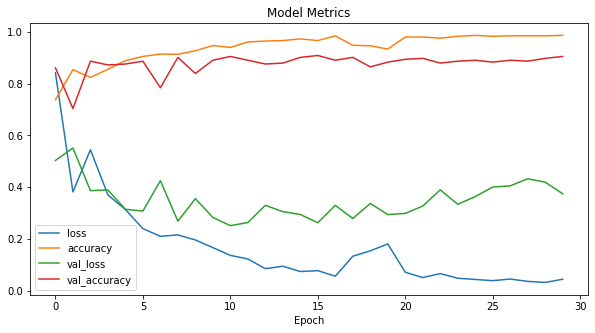

In [30]:
metrics.plot(figsize=(10, 5))
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.show()

In [31]:
print('-------------Training Set----------------')
print(classification_report(train_generator.classes, model.predict(train_generator).round()))
print('-------------Validation Set----------------')
print(classification_report(validation_generator.classes, model.predict(validation_generator).round()))

-------------Training Set----------------
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       604
           1       0.47      0.46      0.46       489

    accuracy                           0.52      1093
   macro avg       0.52      0.52      0.52      1093
weighted avg       0.52      0.52      0.52      1093

-------------Validation Set----------------
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       151
           1       0.50      0.52      0.51       122

    accuracy                           0.55       273
   macro avg       0.55      0.55      0.55       273
weighted avg       0.56      0.55      0.55       273



In [32]:
print(train_generator.class_indices)

{'fire': 0, 'non_fire': 1}


## Transfer Learning

In [18]:
from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet50V2(input_shape=(224, 224, 3),
                                  include_top=False,
                                  weights='imagenet')

In [19]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
35/35 [==============================] - 152s 4s/step - loss: 0.5294 - accuracy: 0.8536 - val_loss: 1702.3840 - val_accuracy: 0.4469
Epoch 2/30
35/35 [==============================] - 140s 4s/step - loss: 0.9883 - accuracy: 0.7704 - val_loss: 1582.8765 - val_accuracy: 0.4322
Epoch 3/30
35/35 [==============================] - 140s 4s/step - loss: 0.5442 - accuracy: 0.7978 - val_loss: 395.2958 - val_accuracy: 0.4432
Epoch 4/30
35/35 [==============================] - 141s 4s/step - loss: 0.4610 - accuracy: 0.8408 - val_loss: 888.5311 - val_accuracy: 0.5092
Epoch 5/30
35/35 [==============================] - 141s 4s/step - loss: 0.3848 - accuracy: 0.8811 - val_loss: 1850.6334 - val_accuracy: 0.4579
Epoch 6/30
35/35 [==============================] - 143s 4s/step - loss: 0.2327 - accuracy: 0.9085 - val_loss: 78.3699 - val_accuracy: 0.7033
Epoch 7/30
35/35 [==============================] - 143s 4s/step - loss: 0.8470 - accuracy: 0.8143 - val_loss: 62028.4531 - val_accuracy: 0.

KeyboardInterrupt: 

In [ ]:
metrics = pd.DataFrame(history.history)

In [ ]:
metrics[['loss', 'val_loss']].plot(figsize=(10, 5))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.show()

In [ ]:
metrics[['accuracy', 'val_accuracy']].plot(figsize=(10, 5))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print('-------------Training Set----------------')
print(classification_report(train_generator.classes, model.predict(train_generator).round()))
print('-------------Validation Set----------------')
print(classification_report(validation_generator.classes, model.predict(validation_generator).round()))

In [ ]:
model.evaluate(validation_generator)

## Inference

In [33]:
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize

def load_and_preprocess(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [34]:
new_img1 = load_and_preprocess('fire.jpeg')
new_img2 = load_and_preprocess('nonfire.jpeg')

In [35]:
new_img1.shape

TensorShape([224, 224, 3])

In [36]:
new_img2.shape

TensorShape([224, 224, 3])

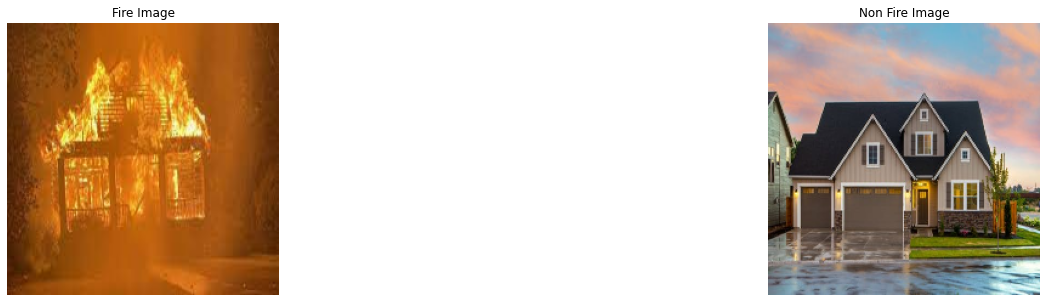

In [37]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.imshow(new_img1)
plt.title('Fire Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(new_img2)
plt.title('Non Fire Image')
plt.axis('off')
plt.show()

In [38]:
from tensorflow import expand_dims
# benerin dimensi
new_img1 = expand_dims(new_img1, axis=0)
new_img2 = expand_dims(new_img2, axis=0)

In [39]:
res = model.predict(new_img1)
res.argmax()

0

In [40]:
res = model.predict(new_img2)
res.argmax()

0